InceptionV3

In [4]:
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

Check Image Corruption

In [5]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


In [6]:
def preprocess_image(image_path, size=(224, 224)):
    try:
        img = Image.open(image_path)
        
        # Quality enhancement
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)  # Increase sharpness
        
        # Noise reduction
        image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Consistency
        img = img.resize(size, Image.LANCZOS)

        # Normalization
        img_array = np.array(img) / 255.0
    
        # Convert back to image
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        
        return img
    except (UnidentifiedImageError, IOError) as e:
        print(f"Error processing image {image_path}: {e}")
        return None

input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

# Apply preprocessing and save to new directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            if preprocessed_img:
                preprocessed_img.save(os.path.join(output_category_path, image_name))


In [7]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [8]:
def create_inceptionv3_model(optimizer='adam', init_mode='uniform', l2_rate=0.01):
    # Load an InceptionV3 model pre-trained on ImageNet
    base_model = InceptionV3(include_top=False, 
                             weights='imagenet', 
                             input_tensor=Input(shape=(224, 224, 3)))

    # Adding custom layers on top of InceptionV3
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(21, activation='softmax')(x)
    
    # Construct the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Freeze the layers of the base model to not train them again
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Replace the model creation line with the new InceptionV3 model
model = create_inceptionv3_model()

In [9]:
import json
import os

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path
        # Create the file initially or clear existing file
        if not os.path.exists(file_path):
            with open(file_path, 'w') as f:
                json.dump({}, f)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_path, 'r+') as f:
            history = json.load(f)
            for key, value in logs.items():
                if key in history:
                    history[key].append(value)
                else:
                    history[key] = [value]
            f.seek(0)  # Go to the beginning of the file
            json.dump(history, f, indent=4)

In [10]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'models/best_Inception_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min',
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping, SaveHistoryCallback('models/inception_history.json')],
)


Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4503 - loss: 12.5298
Epoch 1: val_loss improved from inf to 7.25862, saving model to models/best_Inception_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4517 - loss: 12.5127 - val_accuracy: 0.8000 - val_loss: 7.2586
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7786 - loss: 6.4715
Epoch 2: val_loss improved from 7.25862 to 4.26660, saving model to models/best_Inception_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7786 - loss: 6.4646 - val_accuracy: 0.8181 - val_loss: 4.2666
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7930 - loss: 3.8918
Epoch 3: val_loss improved from 4.26660 to 2.91042, saving model to models/best_Inception_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7931 - loss: 3.8889 - val_accuracy: 0.8067 - val_loss: 2.9104
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8074 - loss: 2.7101
Epoch 4: val_

In [11]:
# Evaluate the model
model = tf.keras.models.load_model('models/best_Inception_model.keras')
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8336 - loss: 1.1746
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8240 - loss: 1.2500
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8355 - loss: 1.2054
Train accuracy: 0.8374, Validation accuracy: 0.8214, Test accuracy: 0.8238


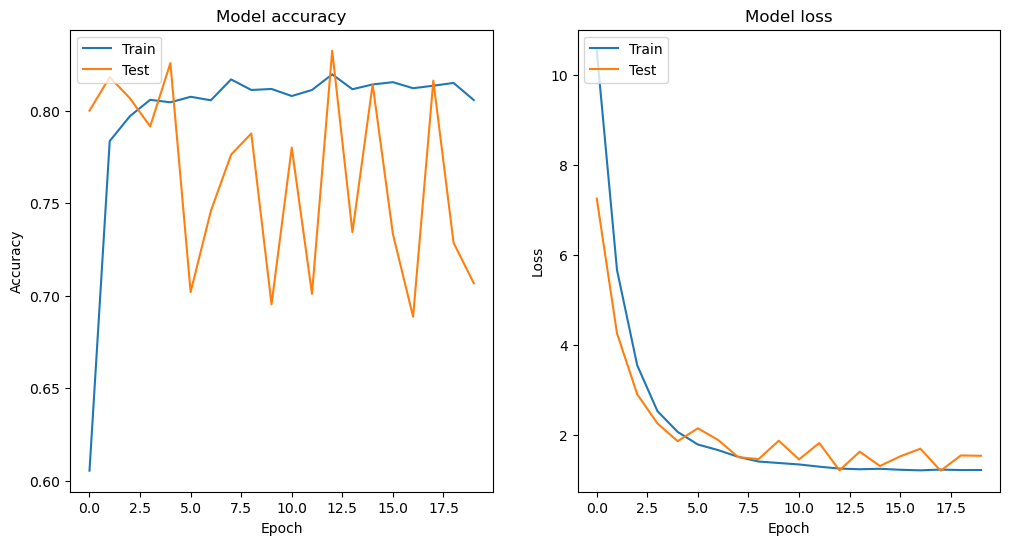

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


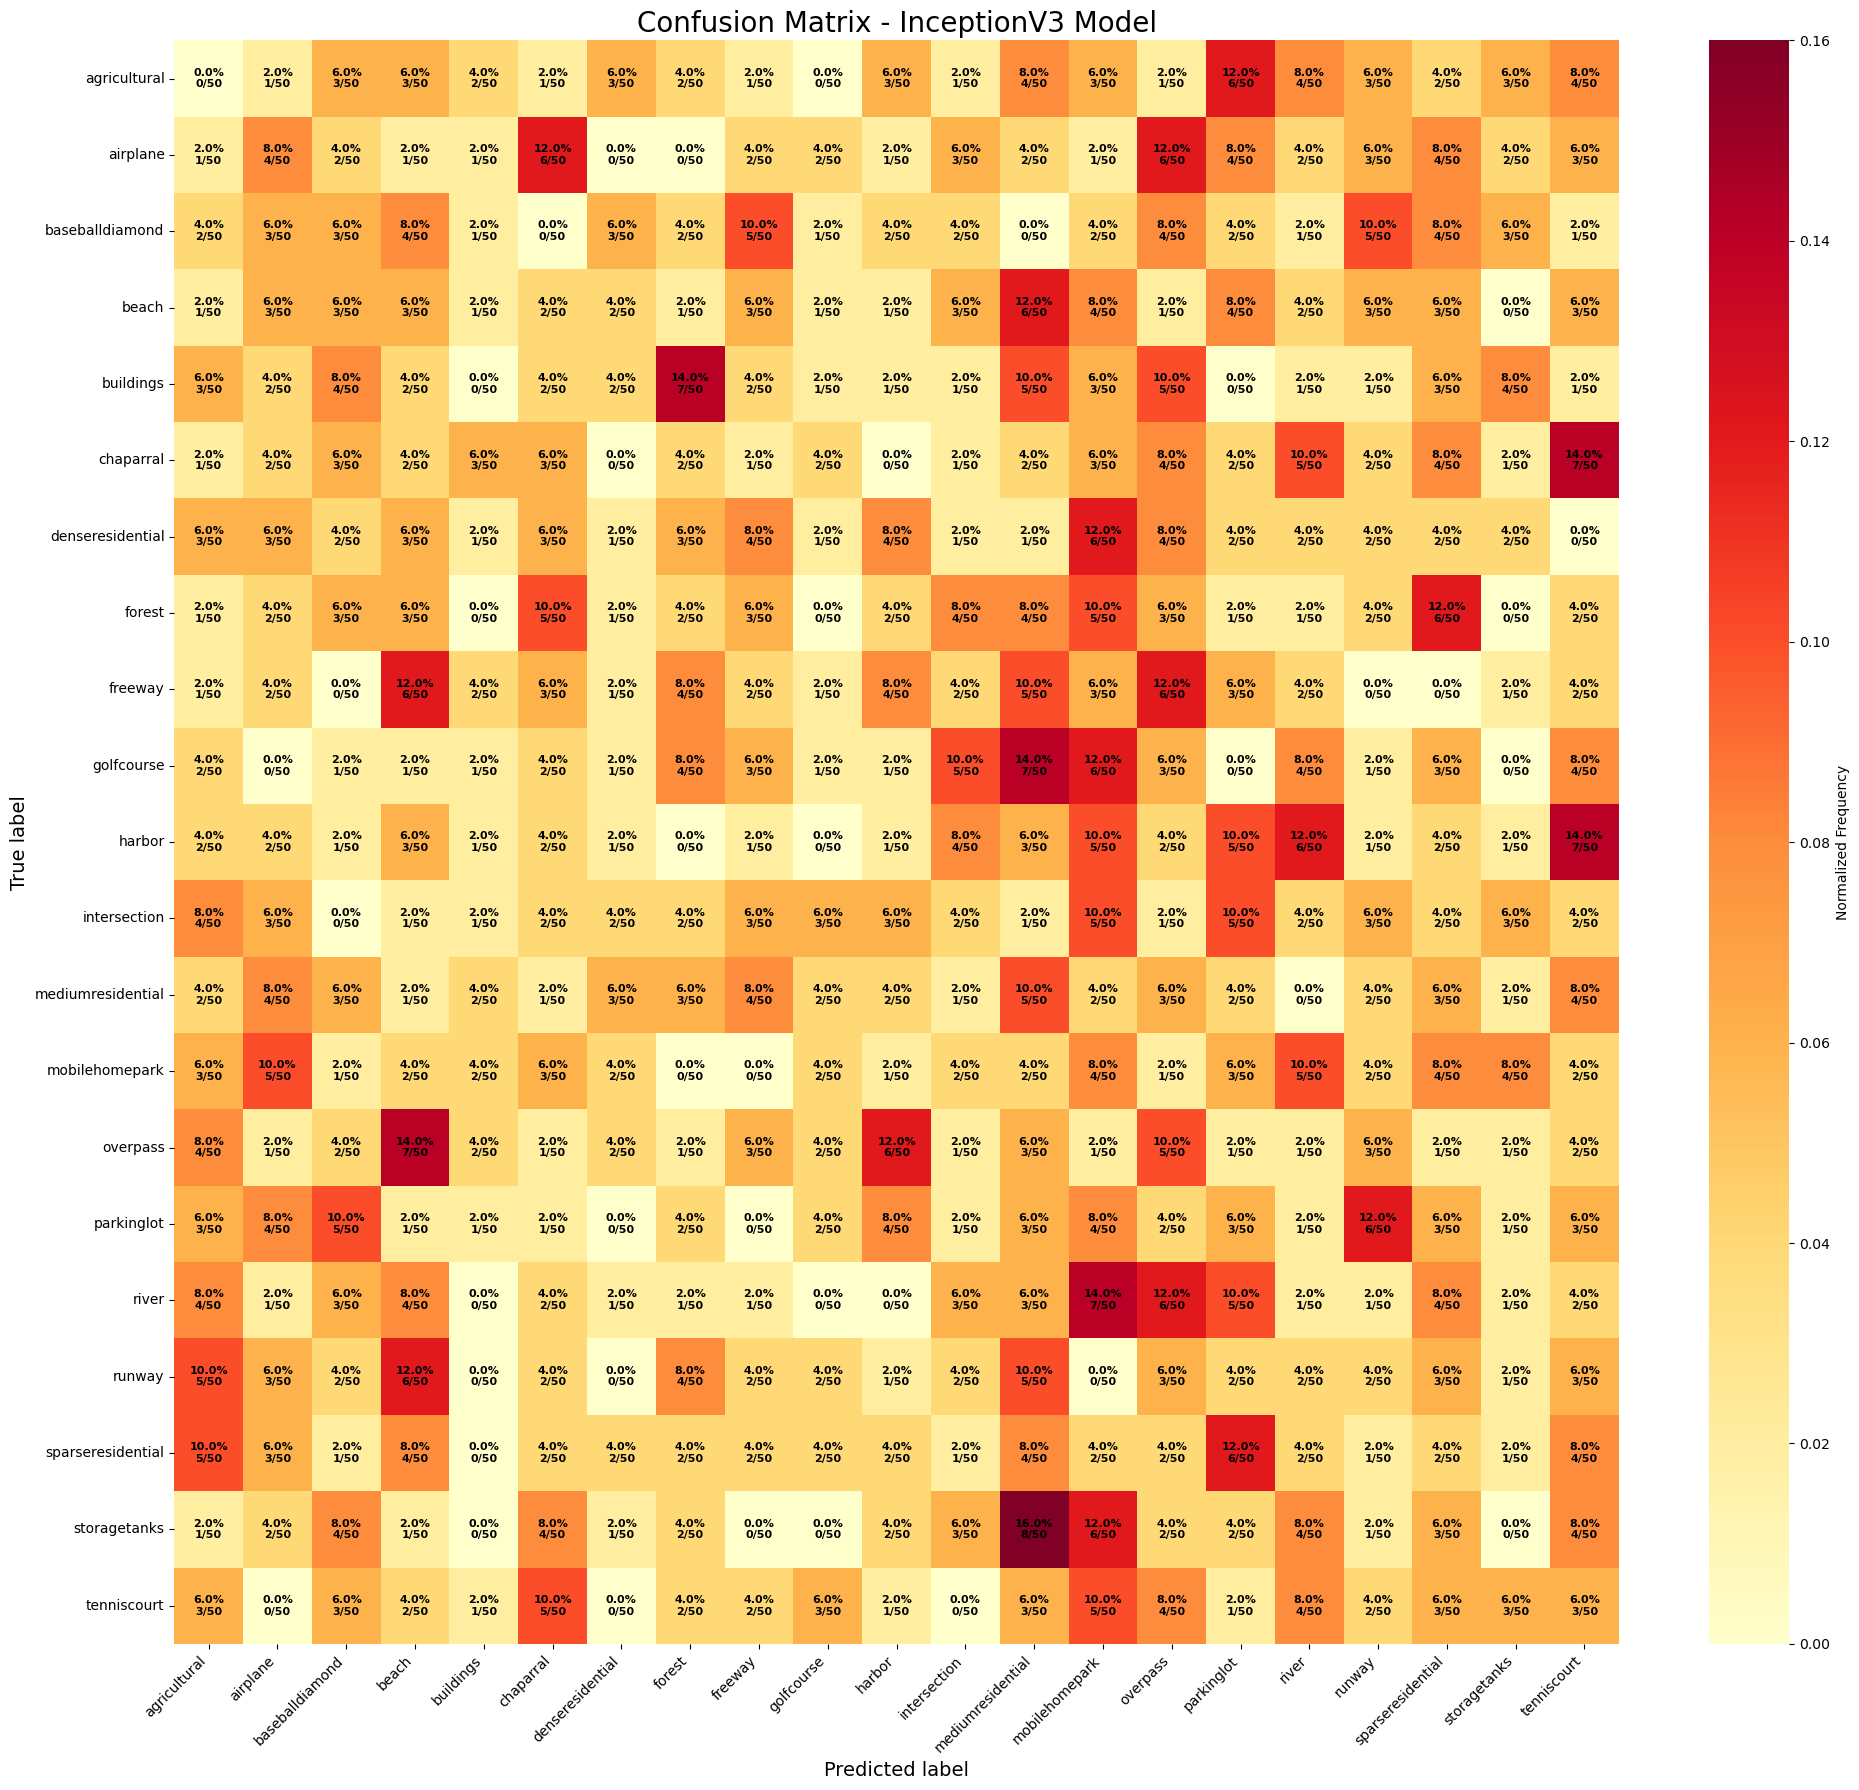

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model (assuming you've saved it during training)
model = load_model('models/best_Inception_model.keras')

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(20, 18))

# Plot the heatmap
sns.heatmap(cm_normalized, annot=False, cmap='YlOrRd', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Normalized Frequency'})

# Customize the plot
plt.title('Confusion Matrix - InceptionV3 Model', fontsize=20)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add text annotations for percentages and absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f"{cm_normalized[i, j]:.1%}\n{cm[i, j]}/{cm[i, :].sum()}", 
                 ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white", 
                 fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()